In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "/content/drive/MyDrive/Proyecto_AI/images"
!ls

/content/drive/MyDrive/Proyecto_AI/images
augmented  images


# Data Augmentation

Usamos ImageDataGenerator para generar imagenes nuevas en el ram mientras entrenamos para no desperdiciar espacio.






**Transformaciones**

Primeramente se reescalan las imágenes para entrenar la red neuronal

Segundo, las características que identifican a la estética Vaporwave de Synthwave y visceversa son la paleta de colores y los elementos que utilizan. Así que se necesitan imágenes que muestren diferentes vistas de estos elementos (rotados y cambiados horizontalmente o verticalmente) y ligeramente estiradas de diferentes partes (pero sin exagerar para que no se deformen), esto se hizo con las transformaciones en la función.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


path = "/content/drive/MyDrive/Proyecto_AI/images"

base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.3,
							height_shift_range = 0.3,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,
							vertical_flip = True)
							



Para ello tenemos que asignar una fuente base de imágenes a modificar, en este caso tomamos las de el directorio de train, en este caso solo estamos tomando una imagen y estamos mostrando como se generarían 5 imágenes diferentes:

Found 225 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

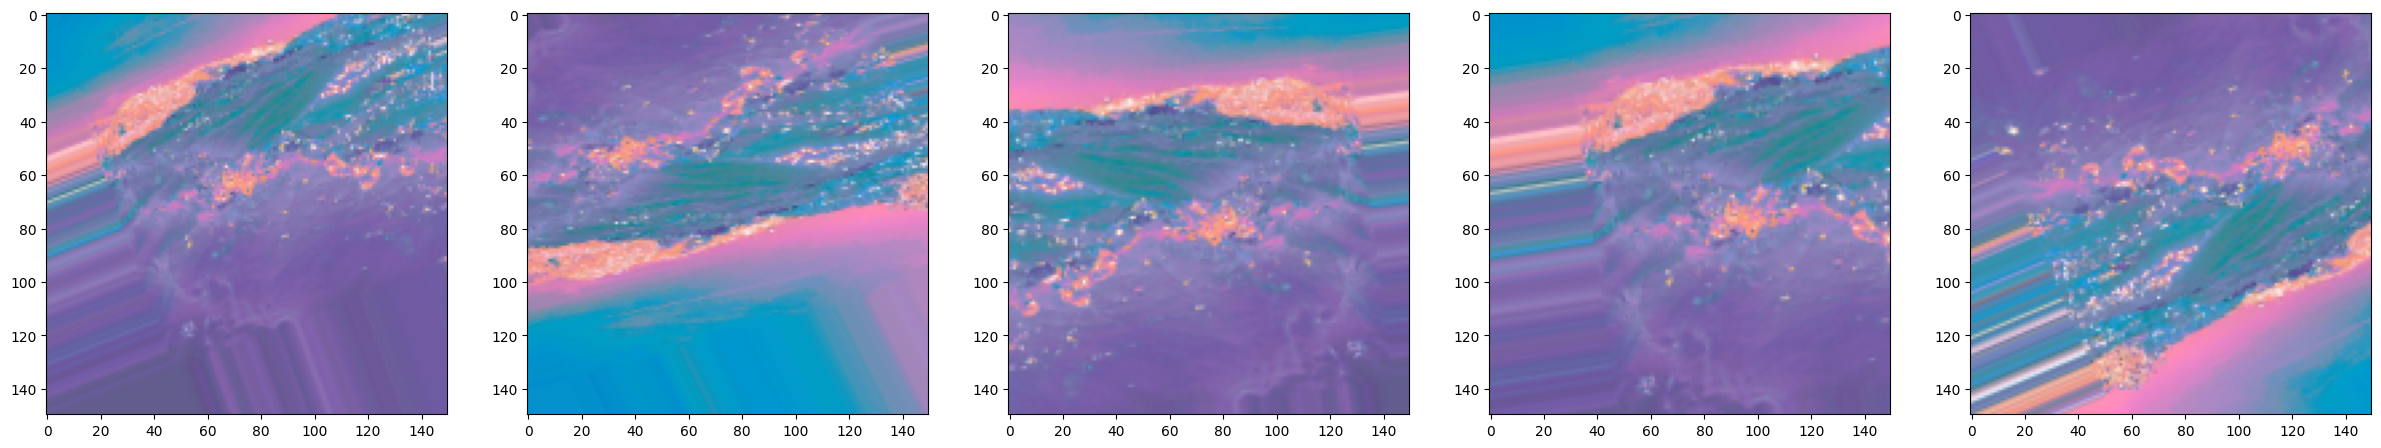

In [5]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 1,
							class_mode ='binary'
							)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

En este caso estamos tomando 8 imágenes y estomos modificando todas 1 vez cada una y las mostramos a manera de ejemplo.

Found 225 images belonging to 2 classes.
(8, 150, 150, 3)
[1. 0. 0. 1. 0. 0. 0. 1.]


<Figure size 640x480 with 0 Axes>

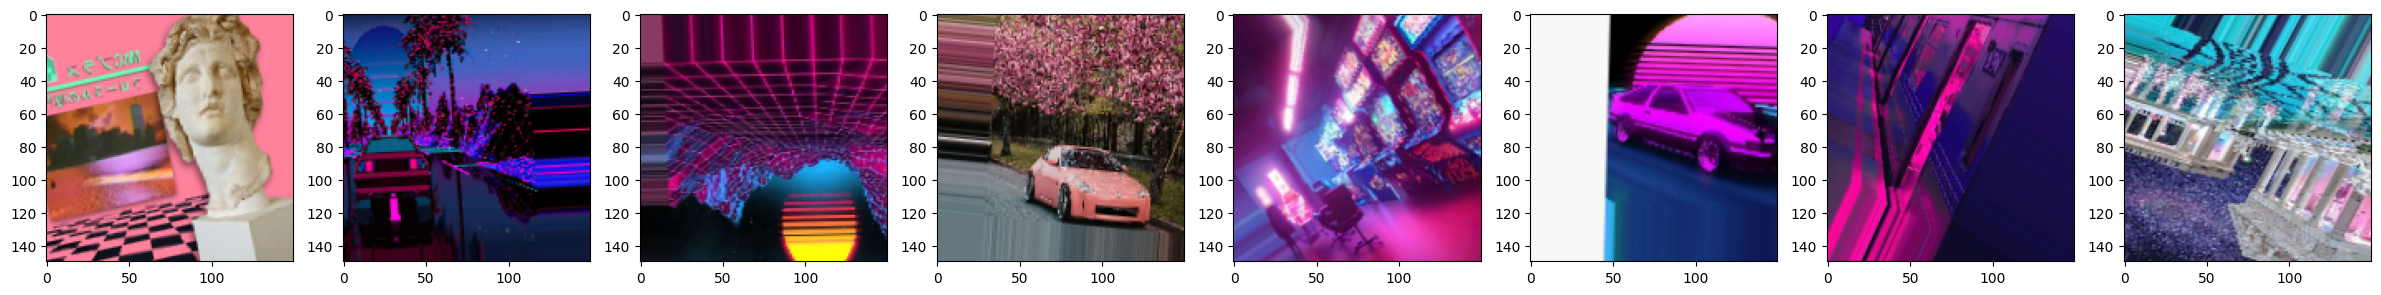

In [6]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary'
							)


images , labels = train_generator[0]

print(images.shape)
print(labels)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]) :  
  axarr[i].imshow(images[i])

También podemos configurar la generación de imágenes para que cada una se salve en el disco duro, de esta forma podemos ver posteriormente con qué imágenes entrenó el modelo. 

In [7]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= path + '/augmented',   
              save_prefix='aug',
              save_format='png'
							)

Found 225 images belonging to 2 classes.


# Red Neuronal 

La arquitectura usada fue la ResNet-50, implementada en el paper "Deep Residual Learning for Image Recognition" por Kaiming He, Xiangyu Zhang, Shaoqing Ren y Jian Sun (https://arxiv.org/abs/1512.03385)

Ya que esta red nos permite agregar más capas sin que haya overfitting, haciendo que pueda ser más precisa y de toda la familia ResNet, esta red es la más fácil de implementar para este proyecto.

In [8]:
from tensorflow.keras import optimizers, models, activations, layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, Flatten, Dense, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D
"""						
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (150,150,3)))
model.add(layers.Conv2D(10, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
"""


def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

		# third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
		# x = Activation(activations.relu)(x)

		# add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x



def res_conv(x, s, filters):
		'''
		here the input size changes''' 
		x_skip = x
		f1, f2 = filters

		# first block
		x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
		# when s = 2 then it is like downsizing the feature map
		x = BatchNormalization()(x)
		x = Activation(activations.relu)(x)

		# second block
		x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
		x = BatchNormalization()(x)
		x = Activation(activations.relu)(x)

		#third block
		x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
		x = BatchNormalization()(x)

		# shortcut 
		x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
		x_skip = BatchNormalization()(x_skip)

		# add 
		x = Add()([x, x_skip])
		x = Activation(activations.relu)(x)

		return x



def resnet50():

		#input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
		input_im = Input(shape=(150,150,3))
		x = ZeroPadding2D(padding=(3, 3))(input_im)

		# 1st stage
		# here we perform maxpooling, see the figure above

		x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
		x = BatchNormalization()(x)
		x = Activation(activations.relu)(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		#2nd stage 
		# frm here on only conv block and identity block, no pooling

		x = res_conv(x, s=1, filters=(64, 256))
		x = res_identity(x, filters=(64, 256))
		x = res_identity(x, filters=(64, 256))

		# 3rd stage

		x = res_conv(x, s=2, filters=(128, 512))
		x = res_identity(x, filters=(128, 512))
		x = res_identity(x, filters=(128, 512))
		x = res_identity(x, filters=(128, 512))

		# 4th stage

		x = res_conv(x, s=2, filters=(256, 1024))
		x = res_identity(x, filters=(256, 1024))
		x = res_identity(x, filters=(256, 1024))
		x = res_identity(x, filters=(256, 1024))
		x = res_identity(x, filters=(256, 1024))
		x = res_identity(x, filters=(256, 1024))

		# 5th stage

		x = res_conv(x, s=2, filters=(512, 2048))
		x = res_identity(x, filters=(512, 2048))
		x = res_identity(x, filters=(512, 2048))

		# ends with average pooling and dense connection

		x = AveragePooling2D((2, 2), padding='same')(x)

		x = Flatten()(x)
		x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x) #multi-class

		# define the model 

		model = Model(inputs=input_im, outputs=x, name='Resnet50')

		return model


model = resnet50()

model.summary()

model.compile(loss = 'binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])


Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 64)  256         ['conv2d[0][0]']          

In [9]:
history = model.fit(
						train_generator, 
						epochs = 30)

Epoch 1/30
29/29 [==============================] - 104s 3s/step - loss: 18.8550 - acc: 0.5244
Epoch 2/30
29/29 [==============================] - 89s 3s/step - loss: 18.7980 - acc: 0.5822
Epoch 3/30
29/29 [==============================] - 88s 3s/step - loss: 18.7211 - acc: 0.6667
Epoch 4/30
29/29 [==============================] - 89s 3s/step - loss: 18.7072 - acc: 0.6444
Epoch 5/30
29/29 [==============================] - 88s 3s/step - loss: 18.6646 - acc: 0.6978
Epoch 6/30
29/29 [==============================] - 90s 3s/step - loss: 18.6006 - acc: 0.7289
Epoch 7/30
29/29 [==============================] - 89s 3s/step - loss: 18.5445 - acc: 0.7956
Epoch 8/30
29/29 [==============================] - 91s 3s/step - loss: 18.5580 - acc: 0.7378
Epoch 9/30
29/29 [==============================] - 89s 3s/step - loss: 18.5323 - acc: 0.7911
Epoch 10/30
29/29 [==============================] - 90s 3s/step - loss: 18.4464 - acc: 0.8133
Epoch 11/30
29/29 [==============================] - 89s 3

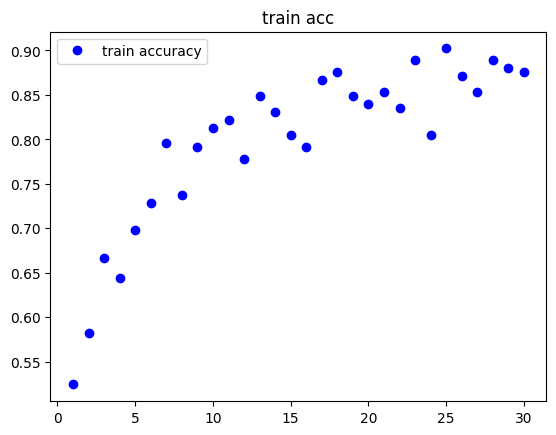

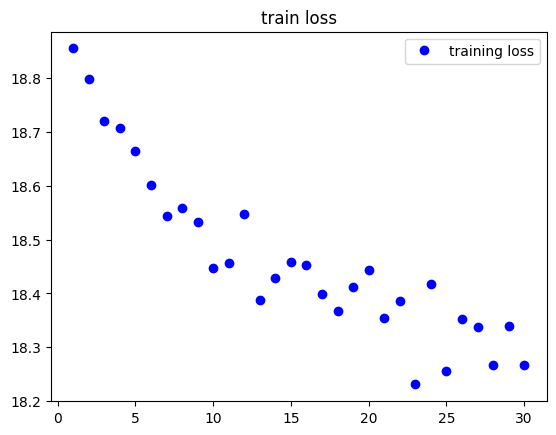

In [10]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [11]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 20,
					class_mode= 'binary')

test_loss, test_acc = model.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)


Found 40 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 2/25 [=>............................] - ETA: 1:00 - loss: 28640.3711 - acc: 0.5000

25/25 [==============================] - 8s 121ms/step - loss: 28640.3711 - acc: 0.5000

test acc :
 0.5


#Matriz de confusión

In [12]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]
print(test_labels)


predictions = model.predict(test_imgs)
classes_x = predictions.T
classes_x

[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
1/1 [==============================] - 3s 3s/step


array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)

In [13]:
from tensorflow.math import confusion_matrix

mat = confusion_matrix(classes_x[0], test_labels)
print('         ', 'label synth ', ' label vapor') 
print('pred synth    ', np.array(mat[0][0]), "          ", np.array(mat[0][1])) 
print('pred vapor    ', np.array(mat[1][0]), "          ", np.array(mat[1][1]))

          label synth   label vapor
pred synth     0            0
pred vapor     11            9


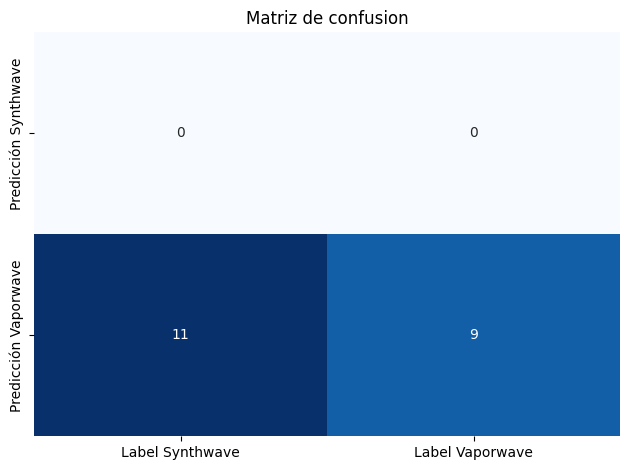

Predicción:  0.45


In [14]:
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

pf = pd.DataFrame(mat, index=['Predicción Synthwave', 'Predicción Vaporwave'], columns=['Label Synthwave', 'Label Vaporwave'])

sns.heatmap(pf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusion"), plt.tight_layout()
plt.show()

TP = np.array(mat[0][0]) + np.array(mat[1][1])
FP = np.array(mat[1][0]) + np.array(mat[0][1])

print("Predicción: ", TP/(TP + FP))

Aún falta refinar el modelo, ya que la predicción es menor que 80%